In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [88]:
df = pd.read_excel(r"data/99acre_raw_data/99acres_property_data_v4.xlsx")

In [89]:
# Step 1: Get numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != 'price']  # Exclude 'price'

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

target_col = 'price'

# Split data into features (X) and target (y)
X = df[numerical_cols + categorical_cols]
y = df[target_col]

In [90]:
# Step 2: Preprocessing Pipelines
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])  # No imputation here
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [94]:
# Step 3: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define models to train
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'Lasso Regression': Lasso(random_state=42),
    'Ridge Regression': Ridge(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
}

In [95]:
# Step 5: Feature Selection using RFE
def select_features_using_rfe(model, X_train, y_train, num_features_to_select=25):
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    
    # Get the feature names after OneHotEncoding
    cat_feature_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
    all_feature_names = numerical_cols + list(cat_feature_names)

    # If the model supports RFE (e.g., RandomForest, LinearRegression)
    if hasattr(model, 'coef_') or hasattr(model, 'feature_importances_'):
        # Use RFE for models that support feature importance or coefficients
        selector = RFE(model, n_features_to_select=num_features_to_select)
        selector.fit(X_train_preprocessed, y_train)
        selected_features = np.array(all_feature_names)[selector.support_]
    else:
        # For models like SVR that do not support RFE, use correlation-based feature selection
        # Calculate correlation between numerical features and the target
        correlation_matrix = pd.DataFrame(X_train, columns=numerical_cols).corrwith(y_train)
        top_features = correlation_matrix.abs().sort_values(ascending=False).head(num_features_to_select).index.tolist()
        selected_features = top_features
    
    # Select all OHE features and combine with selected numerical features
    selected_ohe_features = list(cat_feature_names)  # All OneHotEncoded features
    final_selected_features = selected_ohe_features + selected_features
    return final_selected_features

# Step 6: Cross-validation (K-fold)
def cross_validate_model(model, X_train, y_train):
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    scores = cross_val_score(model, X_train_preprocessed, y_train, cv=5, scoring='r2')
    return scores.mean(), scores.std()

# Step 7: Hyperparameter tuning using GridSearchCV
def tune_model_hyperparameters(model, param_grid, X_train, y_train):
    # Check if param_grid is None and set default grid for different models
    if param_grid is None:
        if isinstance(model, LinearRegression):
            param_grid = {'model__fit_intercept': [True, False], 'model__positive': [True, False]}  
        elif isinstance(model, RandomForestRegressor):
            param_grid = {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, 7]}  
        elif isinstance(model, SVR):
            param_grid = {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']}  
        elif isinstance(model, KNeighborsRegressor):
            param_grid = {'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']}  
        elif isinstance(model, DecisionTreeRegressor):
            param_grid = {'model__max_depth': [3, 5, 7, 10]}  
        elif isinstance(model, GradientBoostingRegressor):
            param_grid = {'model__n_estimators': [50, 100], 'model__learning_rate': [0.01, 0.1, 0.2]}  
        elif isinstance(model, AdaBoostRegressor):
            param_grid = {'model__n_estimators': [50, 100], 'model__learning_rate': [0.01, 0.1, 0.2]}  
        elif isinstance(model, Lasso):
            param_grid = {'model__alpha': [0.1, 1.0, 10.0]}  
        elif isinstance(model, Ridge):
            param_grid = {'model__alpha': [0.1, 1.0, 10.0]}  
        elif isinstance(model, ElasticNet):
            param_grid = {'model__alpha': [0.1, 1.0, 10.0], 'model__l1_ratio': [0.1, 0.5, 0.9]}  
        elif isinstance(model, xgb.XGBRegressor):
            # Default hyperparameter grid for XGBRegressor
            param_grid = {
                'model__n_estimators': [50, 100],
                'model__learning_rate': [0.01, 0.1, 0.2],
                'model__max_depth': [3, 5, 7],
                'model__subsample': [0.8, 1.0],
                'model__colsample_bytree': [0.8, 1.0],
                'model__gamma': [0, 0.1, 0.2]
            }
        else:
            raise ValueError(f"Unsupported model type for hyperparameter tuning: {type(model)}")
    
    # Wrap the model and preprocessor in a pipeline (if not already done)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_params_, grid_search.best_score_

# Step 8: Evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}

In [96]:
# Store evaluation results
model_results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Feature Selection using RFE
    selected_features = select_features_using_rfe(model, X_train, y_train)
    print(f"Selected Features for {name}: {selected_features}")
    
    # Cross-validation
    mean_cv_score, std_cv_score = cross_validate_model(model, X_train, y_train)
    print(f"Cross-validation (R²): {mean_cv_score:.4f} ± {std_cv_score:.4f}")
    
    # Hyperparameter tuning
    best_params, best_score = tune_model_hyperparameters(model, None, X_train, y_train)
    print(f"Best Hyperparameters for {name}: {best_params} with score: {best_score:.4f}")
    
    # Evaluate model
    results = evaluate_model(model, X_train, X_test, y_train, y_test)
    model_results[name] = results
    print(f"{name} Results: {results}")
    print("="*50)

Training Linear Regression...
Selected Features for Linear Regression: ['facing_East', 'facing_North', 'facing_North-East', 'facing_North-West', 'facing_South', 'facing_South-East', 'facing_South-West', 'facing_West', 'facing_undetermined', 'property_type_flat', 'property_type_house', 'prop_location_ A Block Sushant Lok Phase 1', 'prop_location_ Adarsh Nagar', 'prop_location_ Ambience Island', 'prop_location_ Ansal Plaza', "prop_location_ Ansal's Palam Vihar", 'prop_location_ Arjun Nagar', 'prop_location_ Ashok Vihar', 'prop_location_ Ashok Vihar Phase 2', 'prop_location_ Ashok Vihar Phase 3 Extension', 'prop_location_ Ashok Vihar Phase I', 'prop_location_ B Block Sushant Lok Phase 1', 'prop_location_ BPTP', 'prop_location_ Baldev Nagar', 'prop_location_ Bhawani Enclave', 'prop_location_ Bhim Nagar', 'prop_location_ Bhimgarh Kheri Phase 3', 'prop_location_ Bhondsi', 'prop_location_ Bhora Kalan', 'prop_location_ Bissar', 'prop_location_ Block A Surya Vihar', 'prop_location_ Block H Asho

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.605e+17, tolerance: 2.135e+14
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.657e+17, tolerance: 2.148e+14
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.808e+17, tolerance: 2.350e+14
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.013e+17, tolerance: 2.383e+14
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.750e+17, tolerance: 2.249e+14


Cross-validation (R²): 0.6614 ± 0.0300


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.369e+17, tolerance: 2.817e+14


Best Hyperparameters for Lasso Regression: {'model__alpha': 10.0} with score: 0.6620


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.517e+17, tolerance: 2.817e+14


Lasso Regression Results: {'MAE': 9360453.015930766, 'MSE': 246800450852981.62, 'RMSE': 15709883.85867259, 'R²': 0.548628639861718}
Training Ridge Regression...
Selected Features for Ridge Regression: ['facing_East', 'facing_North', 'facing_North-East', 'facing_North-West', 'facing_South', 'facing_South-East', 'facing_South-West', 'facing_West', 'facing_undetermined', 'property_type_flat', 'property_type_house', 'prop_location_ A Block Sushant Lok Phase 1', 'prop_location_ Adarsh Nagar', 'prop_location_ Ambience Island', 'prop_location_ Ansal Plaza', "prop_location_ Ansal's Palam Vihar", 'prop_location_ Arjun Nagar', 'prop_location_ Ashok Vihar', 'prop_location_ Ashok Vihar Phase 2', 'prop_location_ Ashok Vihar Phase 3 Extension', 'prop_location_ Ashok Vihar Phase I', 'prop_location_ B Block Sushant Lok Phase 1', 'prop_location_ BPTP', 'prop_location_ Baldev Nagar', 'prop_location_ Bhawani Enclave', 'prop_location_ Bhim Nagar', 'prop_location_ Bhimgarh Kheri Phase 3', 'prop_location_ B

In [97]:
# Step 9: Display Results
results_df = pd.DataFrame(model_results).T
print(results_df.sort_values('R²',ascending=False))

                              MAE           MSE          RMSE            R²
XGBoost              3.331893e+06  4.791416e+13  6.922005e+06  9.123702e-01
Random Forest        2.952772e+06  5.585948e+13  7.473920e+06  8.978390e-01
Gradient Boosting    4.340673e+06  7.254788e+13  8.517504e+06  8.673178e-01
Decision Tree        3.912129e+06  9.305894e+13  9.646706e+06  8.298053e-01
Ridge Regression     9.113511e+06  2.182376e+14  1.477287e+07  6.008671e-01
Lasso Regression     9.360453e+06  2.468005e+14  1.570988e+07  5.486286e-01
K-Nearest Neighbors  8.337005e+06  2.543176e+14  1.594734e+07  5.348807e-01
ElasticNet           1.115504e+07  2.910609e+14  1.706051e+07  4.676811e-01
AdaBoost             2.216516e+07  5.708047e+14  2.389152e+07 -4.394004e-02
SVR                  1.312650e+07  5.887005e+14  2.426315e+07 -7.666953e-02
Linear Regression    7.353937e+15  1.270017e+33  3.563730e+16 -2.322724e+18


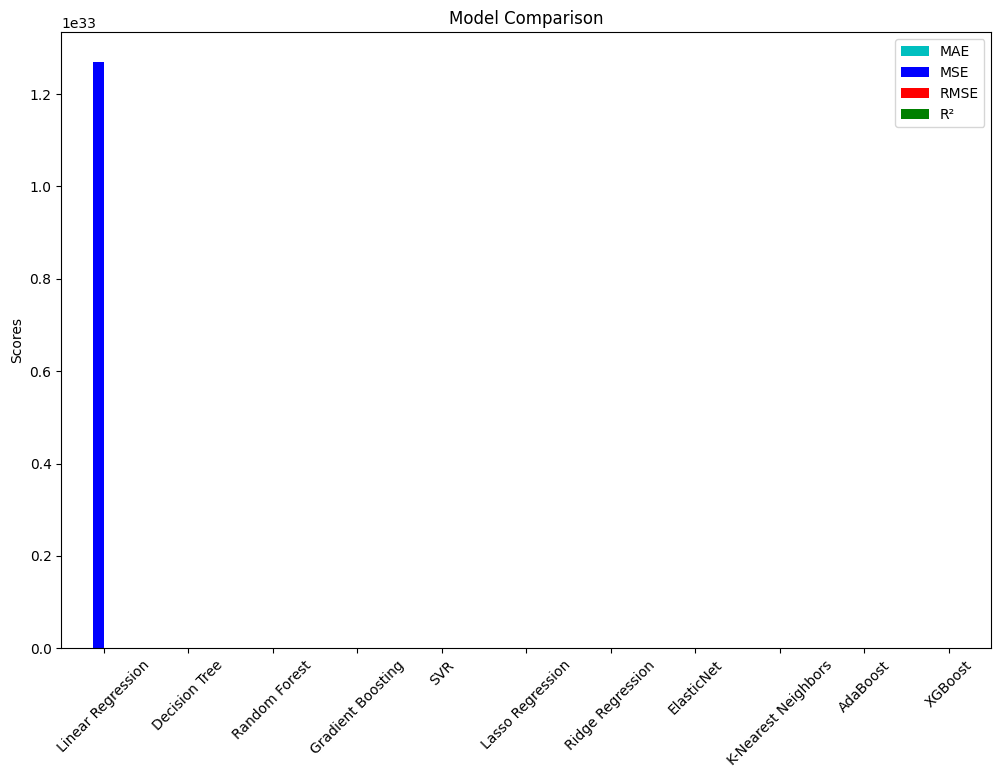

In [98]:
# Step 10: Visualize Comparison of Results
metrics = ['MAE', 'MSE', 'RMSE', 'R²']
results_df[metrics].plot(kind='bar', figsize=(12, 8), color=['c', 'b', 'r', 'g'])
plt.title('Model Comparison')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.show()

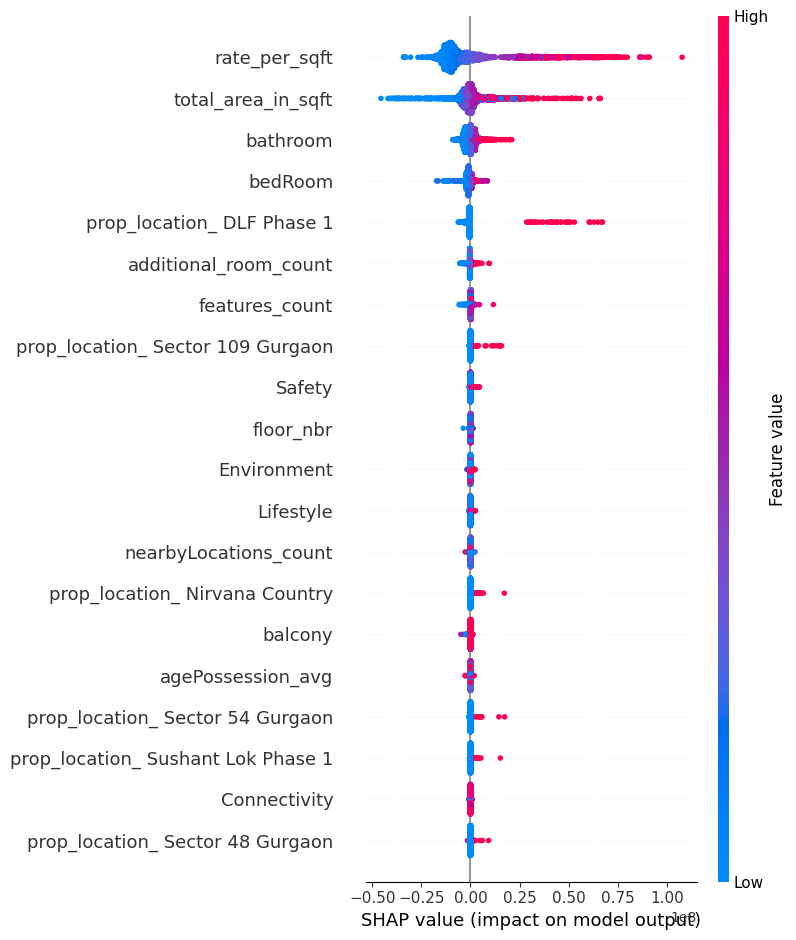

In [100]:
def interpret_model_with_shap(model, X_train, preprocessor, categorical_cols):
    # Apply preprocessing steps
    X_train_preprocessed = preprocessor.fit_transform(X_train)

    # Get the feature names after one-hot encoding (for categorical features)
    cat_feature_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
    all_feature_names = numerical_cols + list(cat_feature_names)

    # Use the transformed data with the correct feature names for SHAP
    shap_values = shap.TreeExplainer(model).shap_values(X_train_preprocessed)

    # Generate the summary plot
    shap.summary_plot(shap_values, features=X_train_preprocessed, feature_names=all_feature_names)

# Example usage for RandomForest (or any tree-based model)
interpret_model_with_shap(models['Random Forest'], X_train, preprocessor, categorical_cols)